In [0]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
from datetime import date, timedelta
from statsmodels.tsa.arima_model import ARIMA
from sklearn.cluster import KMeans

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "/content/drive/My Drive/Datasets/Corona/"
patient_data = path + 'patient.csv'
route_data = path + 'route.csv'
time_data = path + 'time.csv'

df_patient = pd.read_csv(patient_data)
df_route = pd.read_csv(route_data)
df_time = pd.read_csv(time_data)

In [17]:
df_patient.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
0,1.0,female,1984.0,China,filtered at airport,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
1,2.0,male,1964.0,Korea,filtered at airport,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
2,3.0,male,1966.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
3,4.0,male,1964.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
4,5.0,male,1987.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released


id the ID of the patient (n-th confirmed patient)

sex the sex of the patient

birth_year the birth year of the patient

country the country of the patient

region the region of the patient

group the collective infection

infection_reason the reason of infection

infection_order the order of infection

infected_by the ID of who has infected the patient

contact_number the number of contacts with people

confirmed_date the date of confirmation

released_date the date of discharge

deceased_date the date of decease

state isolated / released / deceased

In [18]:
df_patient.isna().sum()

id                     1
sex                 5864
birth_year          5877
country                2
region              5876
group               6202
infection_reason    6139
infection_order     6250
infected_by         6215
contact_number      6235
confirmed_date         1
released_date       6247
deceased_date       6262
state                  1
dtype: int64

In [0]:
df_patient['birth_year'] = df_patient.birth_year.fillna(0.0).astype(int)
df_patient['birth_year'] = df_patient['birth_year'].map(lambda val: val if val > 0 else np.nan)
df_patient.confirmed_date = pd.to_datetime(df_patient.confirmed_date)
daily_count = df_patient.groupby(df_patient.confirmed_date).id.count()
accumulated_count = daily_count.cumsum()
df_patient['age'] = 2020 - df_patient['birth_year'] 

In [0]:
import math
def group_age(age):
    if age >= 0: # not NaN
        if age % 10 != 0:
            lower = int(math.floor(age / 10.0)) * 10
            upper = int(math.ceil(age / 10.0)) * 10 - 1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age + 9) 
            return f"{lower}-{upper}"
    return "Unknown"

df_patient["age_range"] = df_patient["age"].apply(group_age)

In [21]:
df_patient.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state,age,age_range
0,1.0,female,1984.0,China,filtered at airport,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released,36.0,30-39
1,2.0,male,1964.0,Korea,filtered at airport,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released,56.0,50-59
2,3.0,male,1966.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released,54.0,50-59
3,4.0,male,1964.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released,56.0,50-59
4,5.0,male,1987.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released,33.0,30-39


In [0]:
patient=df_patient

###A little bit of preprocessing

In [0]:
date_cols = ["confirmed_date", "released_date", "deceased_date"]
for col in date_cols:
    patient[col] = pd.to_datetime(patient[col])

In [0]:
patient["time_to_release_since_confirmed"] = patient["released_date"] - patient["confirmed_date"]
patient["time_to_death_since_confirmed"] = patient["deceased_date"] - patient["confirmed_date"]
patient["duration_since_confirmed"] = patient[["time_to_release_since_confirmed", "time_to_death_since_confirmed"]].min(axis=1)
patient["duration_days"] = patient["duration_since_confirmed"].dt.days
age_ranges = sorted(set([ar for ar in patient["age_range"] if ar != "Unknown"]))
patient["state_by_gender"] = patient["state"] + "_" + patient["sex"]

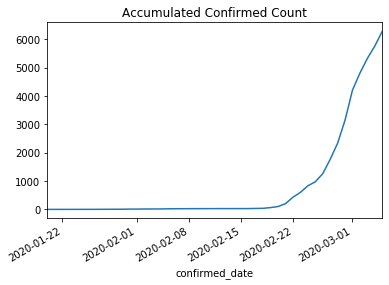

In [25]:
accumulated_count.plot()
plt.title('Accumulated Confirmed Count');

In [27]:
infected_patient = patient.shape[0]
rp = patient.loc[patient["state"] == "released"].shape[0]
dp = patient.loc[patient["state"] == "deceased"].shape[0]
ip = patient.loc[patient["state"]== "isolated"].shape[0]
rp=rp/patient.shape[0]
dp=dp/patient.shape[0]
ip=ip/patient.shape[0]
print("The percentage of recovery is "+ str(rp*100) )
print("The percentage of deceased is "+ str(dp*100) )
print("The percentage of isolated is "+ str(ip*100) )

The percentage of recovery is 0.6364359586316627
The percentage of deceased is 0.36595067621320604
The percentage of isolated is 98.98170246618933


In [28]:
states = pd.DataFrame(patient["state"].value_counts())
states["status"] = states.index
states.rename(columns={"state": "count"}, inplace=True)

fig = px.pie(states,
             values="count",
             names="status",
             title="Current state of patients",
             template="seaborn")
fig.update_traces(rotation=90, pull=0.05, textinfo="value+percent+label")
fig.show()


####People who were released

In [29]:
released = df_patient[df_patient.state == 'released']
released.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state,age,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
0,1.0,female,1984.0,China,filtered at airport,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaT,released,36.0,30-39,17 days,NaT,17 days,17.0,released_female
1,2.0,male,1964.0,Korea,filtered at airport,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaT,released,56.0,50-59,12 days,NaT,12 days,12.0,released_male
2,3.0,male,1966.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaT,released,54.0,50-59,17 days,NaT,17 days,17.0,released_male
3,4.0,male,1964.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaT,released,56.0,50-59,13 days,NaT,13 days,13.0,released_male
4,5.0,male,1987.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaT,released,33.0,30-39,32 days,NaT,32 days,32.0,released_male


####People who are isolated

In [30]:
isolated_state = df_patient[df_patient.state == 'isolated']
isolated_state.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state,age,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
24,25.0,female,1946.0,Korea,capital area,NaN,contact with patient,2.0,27.0,12.0,2020-02-09,NaT,NaT,isolated,74.0,70-79,NaT,NaT,NaT,NaN,isolated_female
25,26.0,male,1968.0,Korea,capital area,NaN,contact with patient,1.0,27.0,0.0,2020-02-09,NaT,NaT,isolated,52.0,50-59,NaT,NaT,NaT,NaN,isolated_male
26,27.0,female,1982.0,China,capital area,NaN,visit to China,1.0,NaN,40.0,2020-02-09,NaT,NaT,isolated,38.0,30-39,NaT,NaT,NaT,NaN,isolated_female
28,29.0,male,1938.0,Korea,capital area,NaN,contact with patient,4.0,83.0,117.0,2020-02-16,NaT,NaT,isolated,82.0,80-89,NaT,NaT,NaT,NaN,isolated_male
29,30.0,female,1952.0,Korea,capital area,NaN,contact with patient,5.0,29.0,27.0,2020-02-16,NaT,NaT,isolated,68.0,60-69,NaT,NaT,NaT,NaN,isolated_female


####Patient who died

In [31]:
dead = df_patient[df_patient.state == 'deceased']
dead.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state,age,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
37,38.0,female,1963.0,Korea,Daegu,NaN,NaN,NaN,NaN,NaN,2020-02-18,NaT,2020-02-23,deceased,57.0,50-59,NaT,5 days,5 days,5.0,deceased_female
53,54.0,male,1963.0,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,2020-02-19,NaT,2020-02-23,deceased,57.0,50-59,NaT,4 days,4 days,4.0,deceased_male
54,55.0,male,1961.0,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,2020-02-19,NaT,2020-02-23,deceased,59.0,50-59,NaT,4 days,4 days,4.0,deceased_male
103,104.0,male,1957.0,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,2020-02-20,NaT,2020-02-19,deceased,63.0,60-69,NaT,-1 days,-1 days,-1.0,deceased_male
106,107.0,male,1953.0,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,2020-02-21,NaT,2020-02-24,deceased,67.0,60-69,NaT,3 days,3 days,3.0,deceased_male


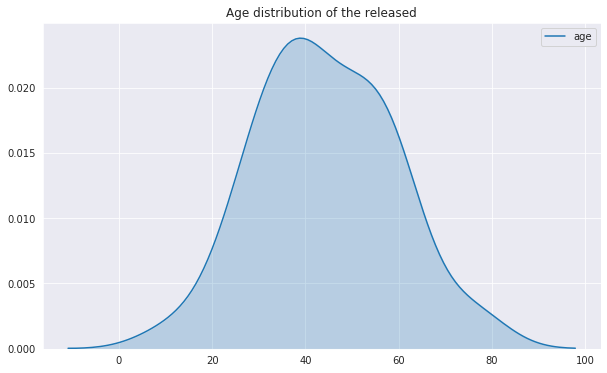

In [32]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the released")
sns.kdeplot(data=released['age'], shade=True)

####Age distribution

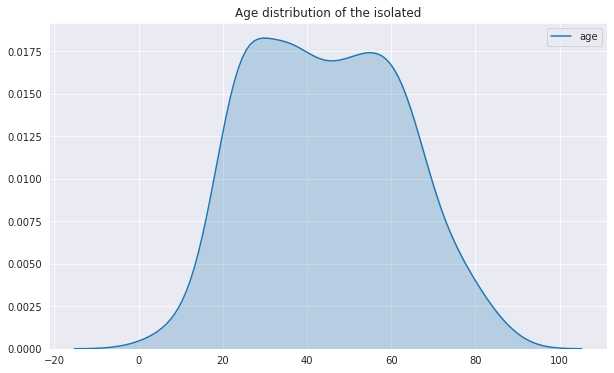

In [33]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the isolated")
sns.kdeplot(data=isolated_state['age'], shade=True)

####Distribution of death with respect to age

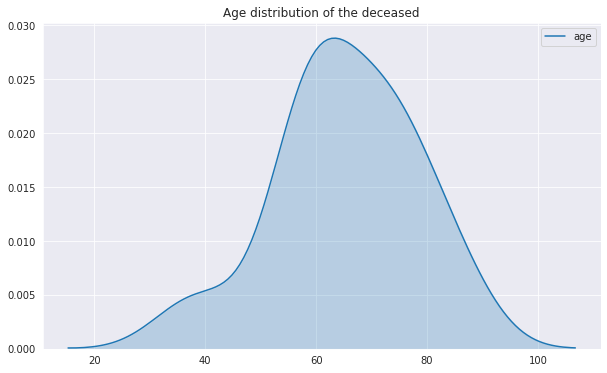

In [34]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the deceased")
sns.kdeplot(data=dead['age'], shade=True)

In [0]:
male_dead = dead[dead.sex=='male']
female_dead = dead[dead.sex=='female']

####Distribution of death by age and gender

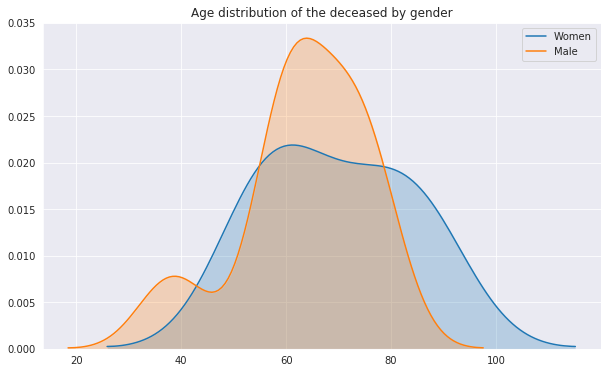

In [36]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the deceased by gender")
sns.kdeplot(data=female_dead['age'], label="Women", shade=True)
sns.kdeplot(data=male_dead['age'],label="Male" ,shade=True)

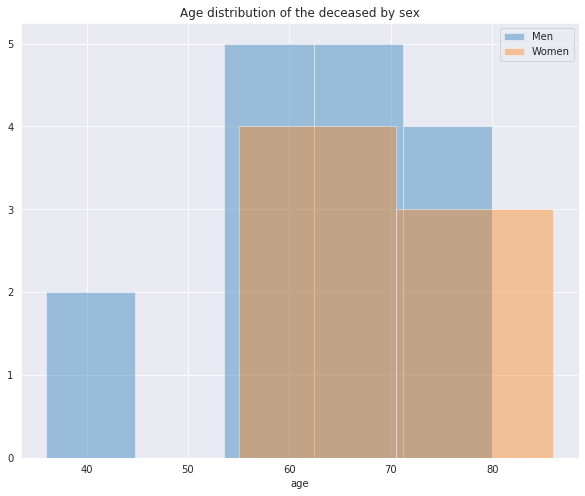

In [37]:
plt.figure(figsize=(10,8))
sns.set_style("darkgrid")
sns.distplot(a=male_dead['age'], label="Men", kde=False)
sns.distplot(a=female_dead['age'], label="Women", kde=False)
plt.title("Age distribution of the deceased by sex")
plt.legend()


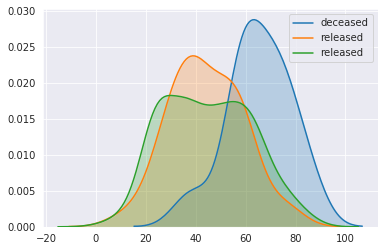

In [38]:
sns.kdeplot(data=dead['age'],label='deceased', shade=True)
sns.kdeplot(data=released['age'],label='released', shade=True)
sns.kdeplot(data=isolated_state['age'],label='released', shade=True)

####Death by gender

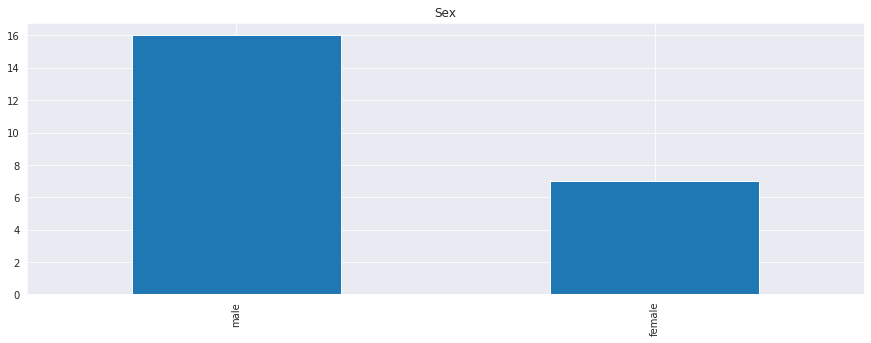

In [39]:
plt.figure(figsize=(15, 5))
plt.title('Sex')
dead.sex.value_counts().plot.bar();

####Infection cause


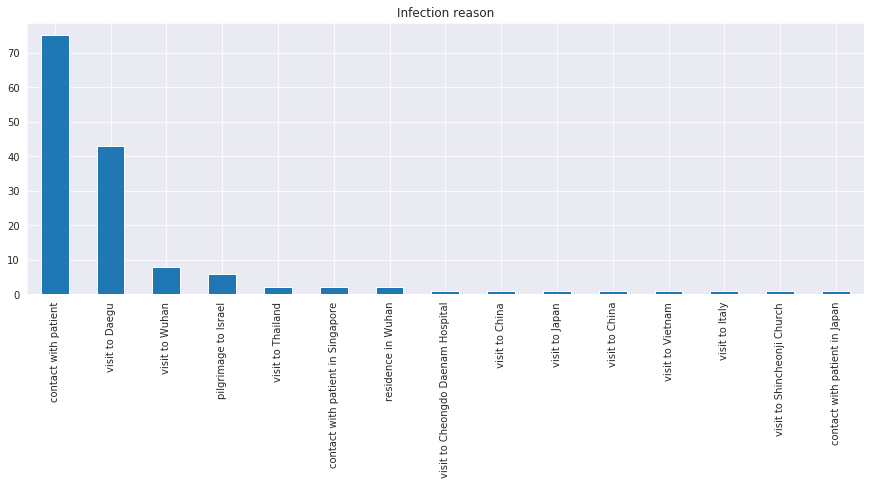

In [40]:
plt.figure(figsize=(15,5))
plt.title('Infection reason')
df_patient.infection_reason.value_counts().plot.bar();

####State

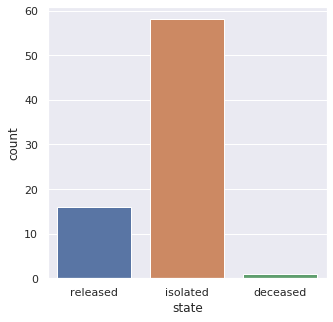

In [41]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[
    (df_patient['infection_reason']=='contact with patient')
])

####Male patients

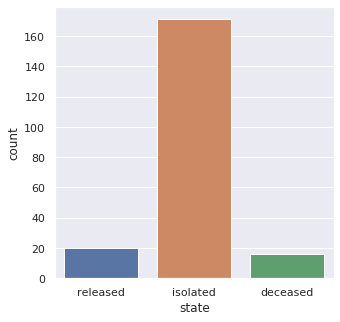

In [42]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[(df_patient['sex']=="male")])

####Female

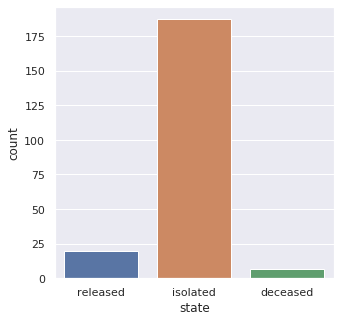

In [43]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[(df_patient['sex']=="female")])

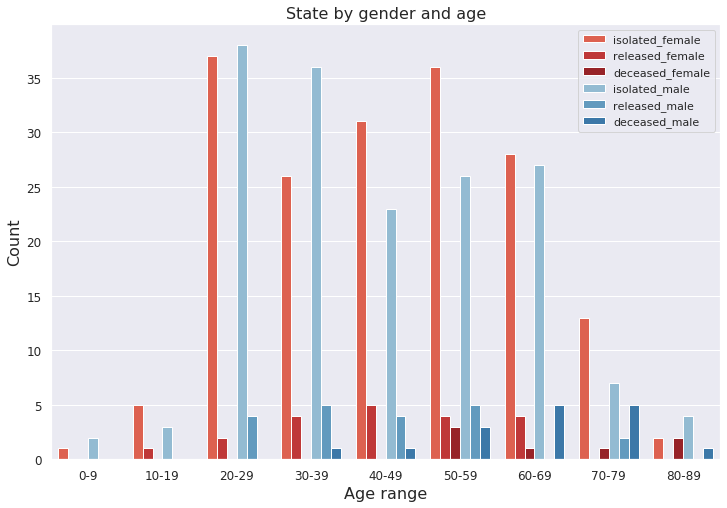

In [44]:
age_gender_hue_order =["isolated_female", "released_female", "deceased_female",
                       "isolated_male", "released_male", "deceased_male"]
custom_palette = sns.color_palette("Reds")[3:6] + sns.color_palette("Blues")[2:5]

plt.figure(figsize=(12, 8))
sns.countplot(x = "age_range",
              hue="state_by_gender",
              order=age_ranges,
              hue_order=age_gender_hue_order,
              palette=custom_palette,
              data=patient)
plt.title("State by gender and age", fontsize=16)
plt.xlabel("Age range", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper right")
plt.show()

In [45]:
df_route.head()

,id,date,province,city,visit,latitude,longitude
0,1,2020-01-19,Incheon,Jung-gu,airport,37.460459,126.440680
1,1,2020-01-20,Incheon,Seo-gu,hospital_isolated,37.478832,126.668558
2,2,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.562143,126.801884
3,2,2020-01-23,Seoul,Jung-gu,hospital_isolated,37.567454,127.005627
4,3,2020-01-20,Incheon,Jung-gu,airport,37.460459,126.440680


Checking if any null value

In [46]:
df_route.isna().sum()

id           0
date         0
province     0
city         0
visit        0
latitude     0
longitude    0
dtype: int64

In [47]:
clus=df_route.loc[:,['id','latitude','longitude']]
clus.head(10)

,id,latitude,longitude
0,1,37.460459,126.440680
1,1,37.478832,126.668558
2,2,37.562143,126.801884
3,2,37.567454,127.005627
4,3,37.460459,126.440680
5,3,37.524978,127.027718
6,3,37.503359,127.049177
7,3,37.524669,127.015911
8,3,37.529200,127.032597
9,3,37.674192,126.776955


####Checking number of clusters

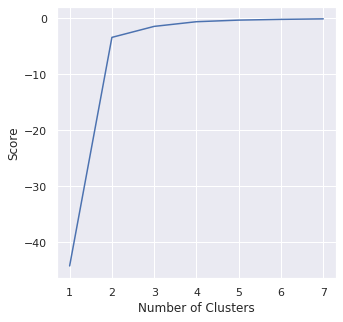

In [48]:
K_clusters = range(1,8)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_route[['latitude']]
X_axis = df_route[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

In [0]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(clus[clus.columns[1:3]])
clus['cluster_label'] = kmeans.fit_predict(clus[clus.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(clus[clus.columns[1:3]])

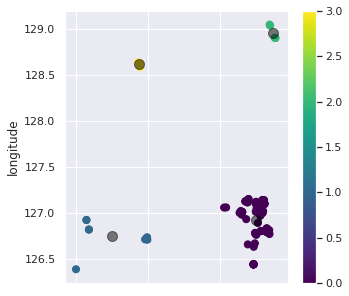

In [50]:
clus.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

In [51]:
import folium
southkorea_map = folium.Map(location=[36.55,126.983333 ], zoom_start=7,tiles='Stamen Toner')

for lat, lon,city in zip(df_route['latitude'], df_route['longitude'],df_route['city']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color='red',
                      popup =('City: ' + str(city) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(southkorea_map)
southkorea_map

####Number of patient per city

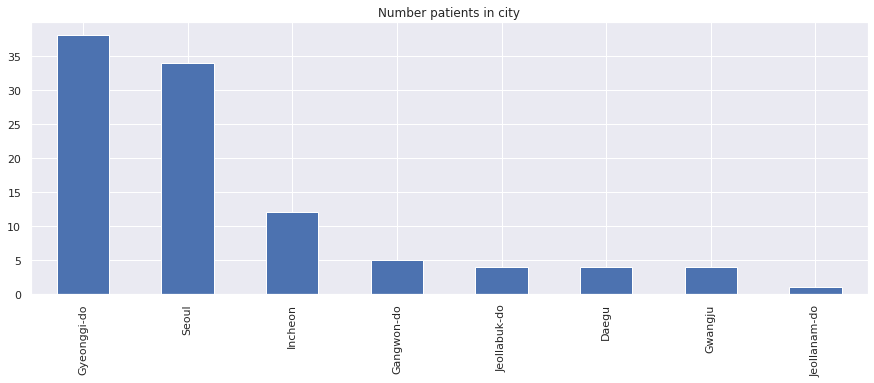

In [52]:
plt.figure(figsize=(15,5))
plt.title('Number patients in city')
df_route.province.value_counts().plot.bar();

####Patient per state

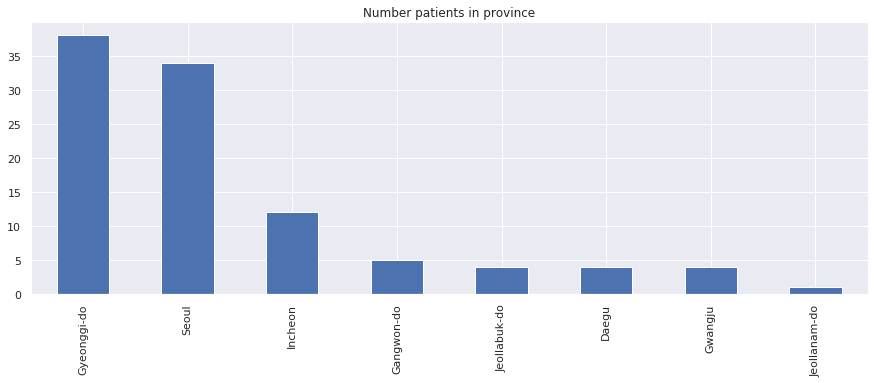

In [53]:
plt.figure(figsize=(15,5))
plt.title('Number patients in province')
df_route.province.value_counts().plot.bar();

####Infections Area

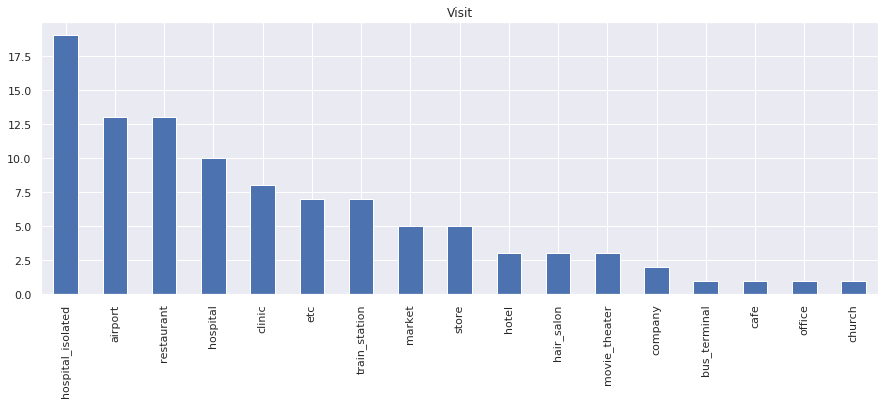

In [54]:
plt.figure(figsize=(15,5))
plt.title('Visit')
df_route.visit.value_counts().plot.bar();

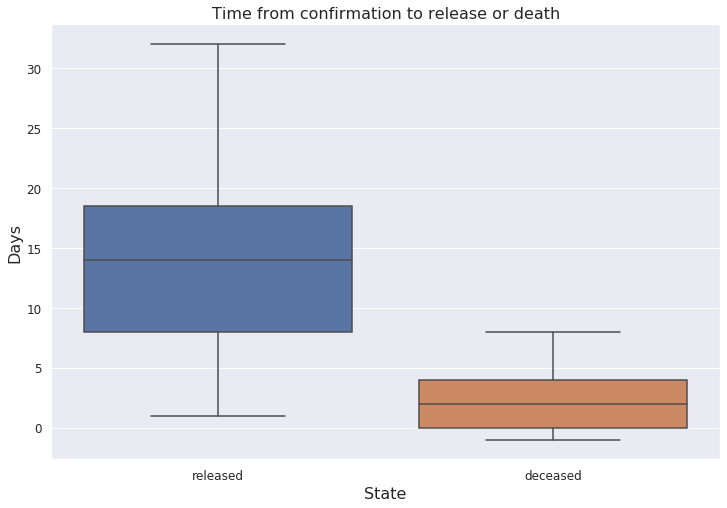

In [55]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="state",
            y="duration_days",
            order=["released", "deceased"],
            data=patient)
plt.title("Time from confirmation to release or death", fontsize=16)
plt.xlabel("State", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()